# NAWEA WOMBAT Interactive Example

In [1]:
from time import perf_counter
from pprint import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wombat import Simulation
from wombat.utilities import plot

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Set up and demonstration of `Simulation`

In [2]:
library_path = Path("../library/corewind/")

sim_in_situ = Simulation(library_path=library_path, config="morro_bay_in_situ.yaml", random_seed=34)
sim_ttp = Simulation(library_path=library_path, config="morro_bay_tow_to_port.yaml", random_seed=34)

### View the farm to verify it's what we saw in the slides

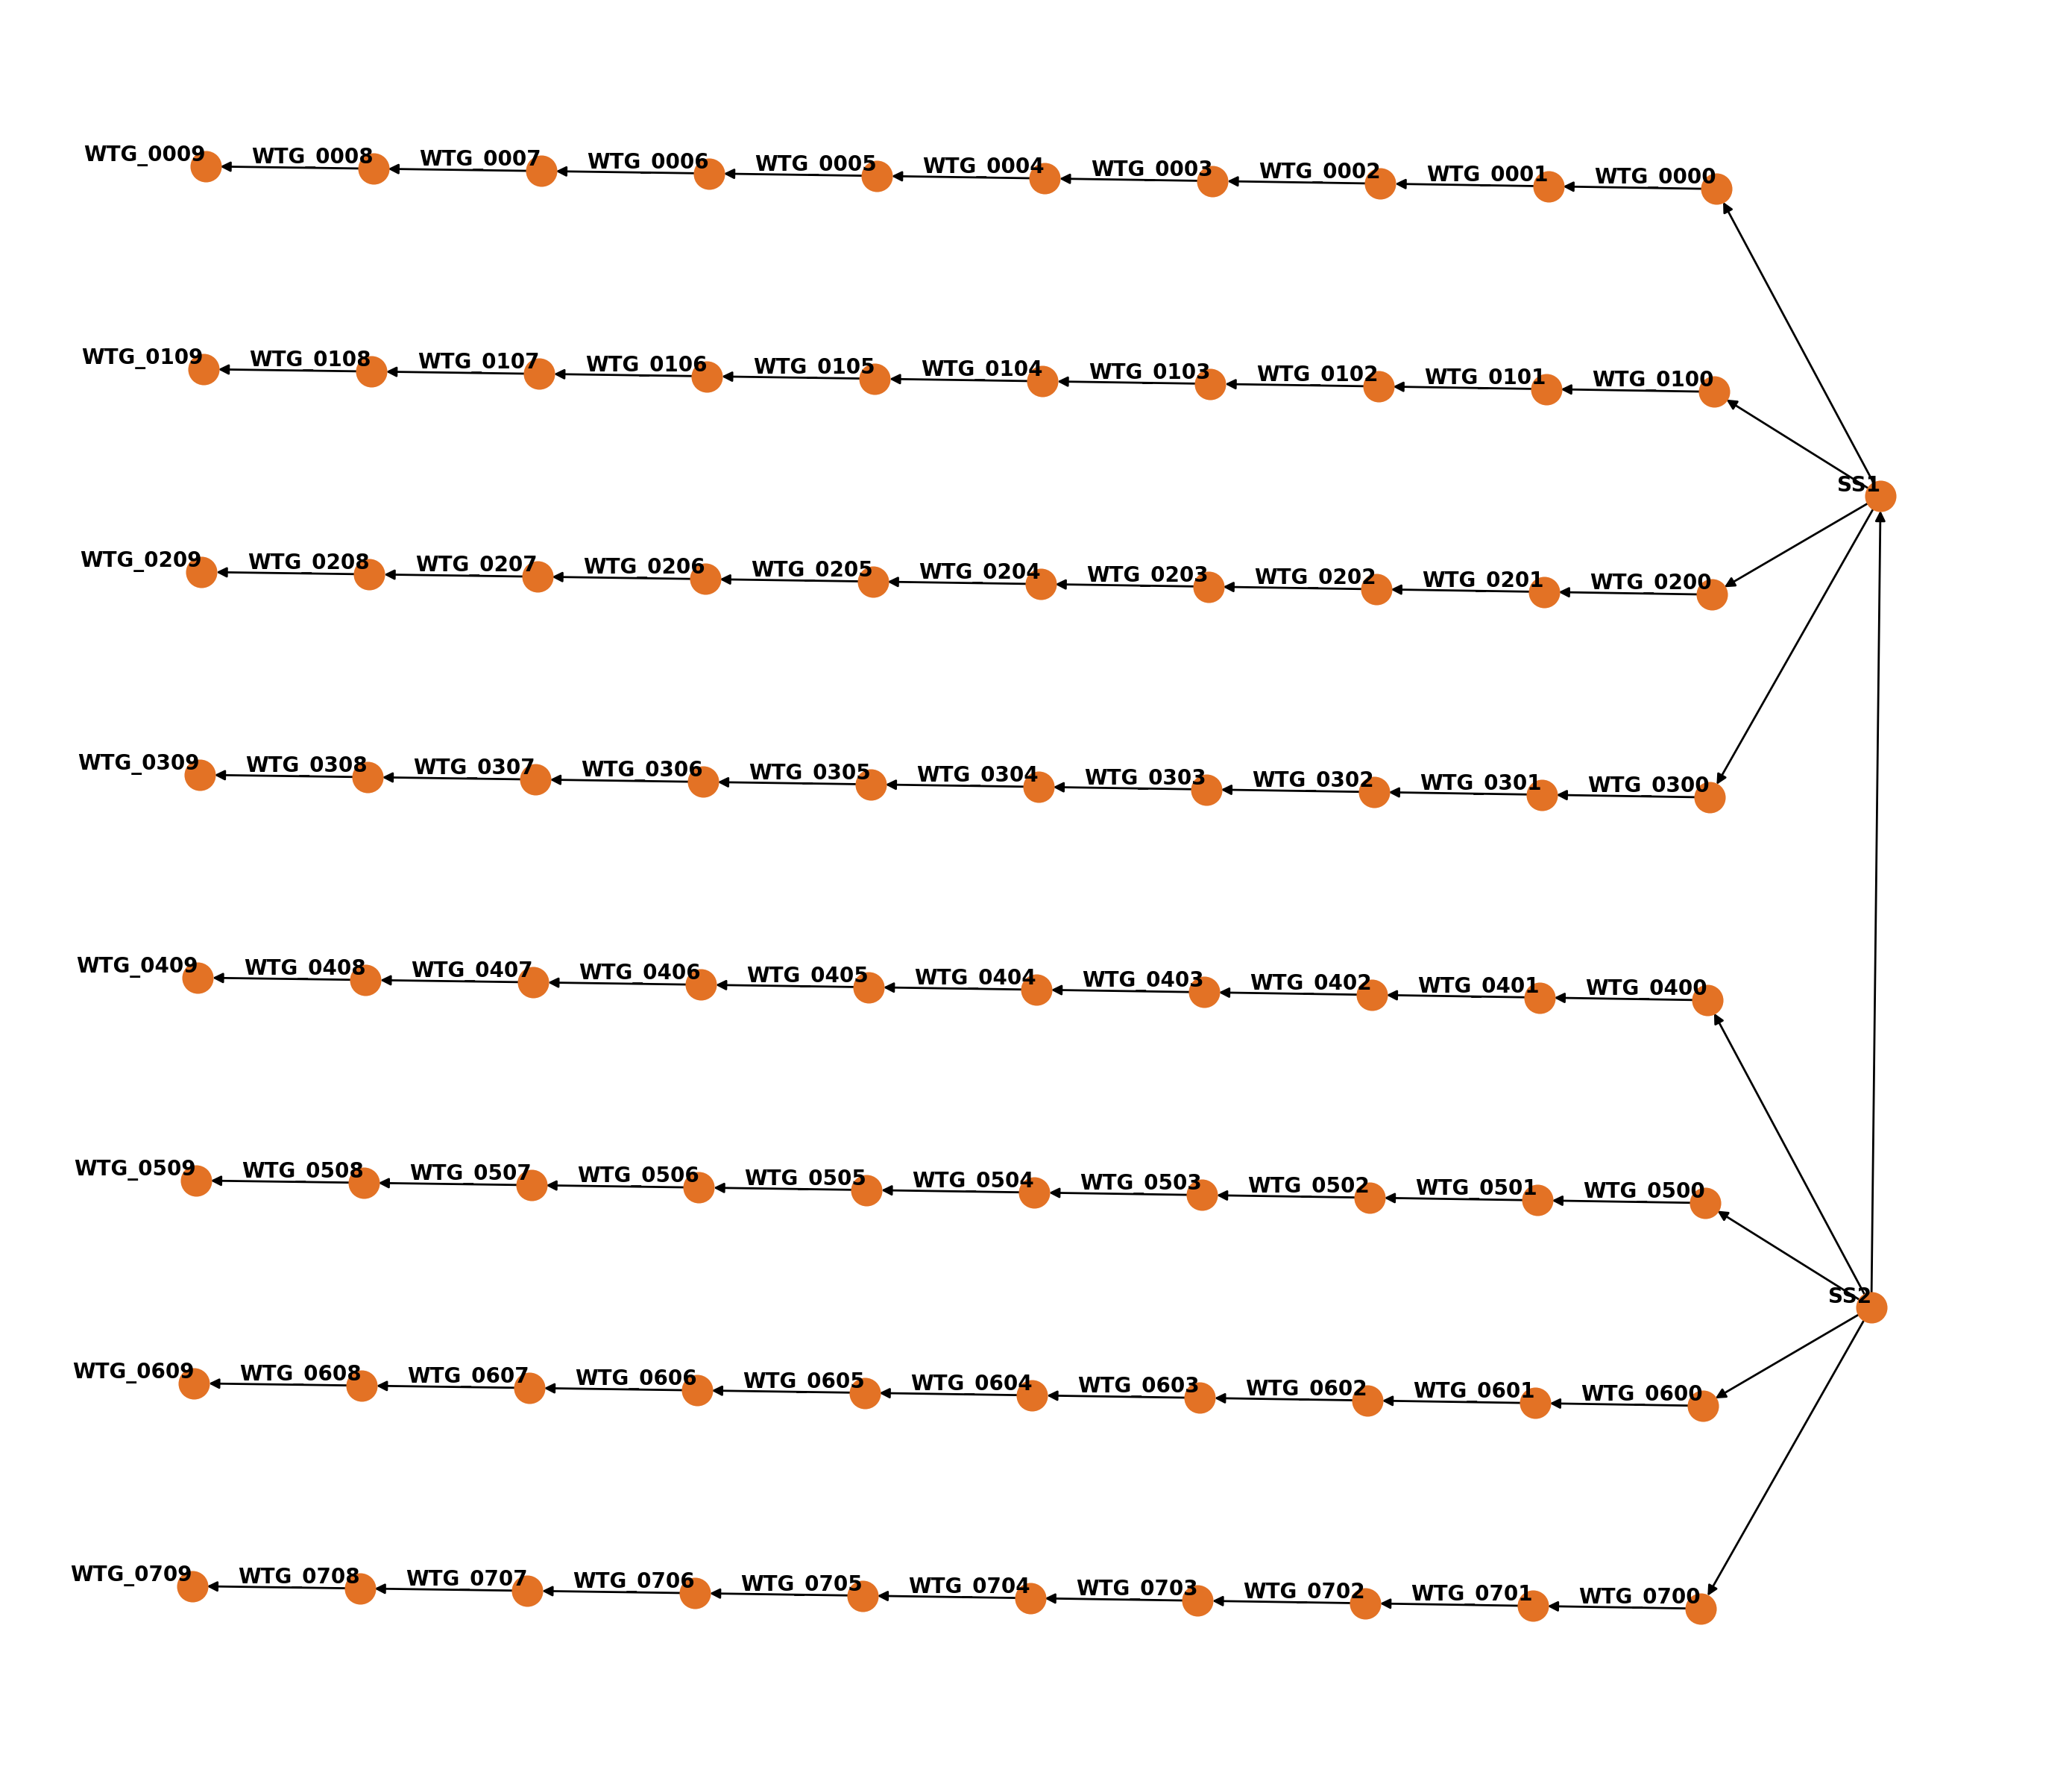

In [3]:
plot.plot_farm_layout(sim_in_situ.windfarm, plot_kwargs={"node_size": 200})

### Show some of the connections that `Simulation` creates that can be helpful for debugging

In [4]:
list(sim_in_situ.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Heavy Lift Vessel']

In [5]:
list(sim_ttp.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Tugboat 1',
 'Tugboat 2']

In [6]:
sim_in_situ.service_equipment["Crew Transfer Vessel 1"].settings.workday_start

6

In [7]:
sim_in_situ.service_equipment["Heavy Lift Vessel"].settings.workday_start

0

## Run the simulations

In [8]:
start = perf_counter()
sim_in_situ.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 86.46 seconds


In [9]:
start = perf_counter()
sim_ttp.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 283.65 seconds


## View the results

Now a `metrics` object will be available through the `Simulation` that gives access to the results methods

### Availability

In [10]:
print("In Situ Availability")
print(f'Time-based: {sim_in_situ.metrics.time_based_availability("project", "windfarm").values[0][0]:.2%}')
print(f'Production-based: {sim_in_situ.metrics.production_based_availability("project", "windfarm").values[0][0]:.2%}')
print()
print("Tow-to-Port Availability")
print(f'Time-based: {sim_ttp.metrics.time_based_availability("project", "windfarm").values[0][0]:.2%}')
print(f'Production-based: {sim_ttp.metrics.production_based_availability("project", "windfarm").values[0][0]:.2%}')

In Situ Availability
Time-based: 99.36%
Production-based: 89.20%

Tow-to-Port Availability
Time-based: 98.14%
Production-based: 92.49%


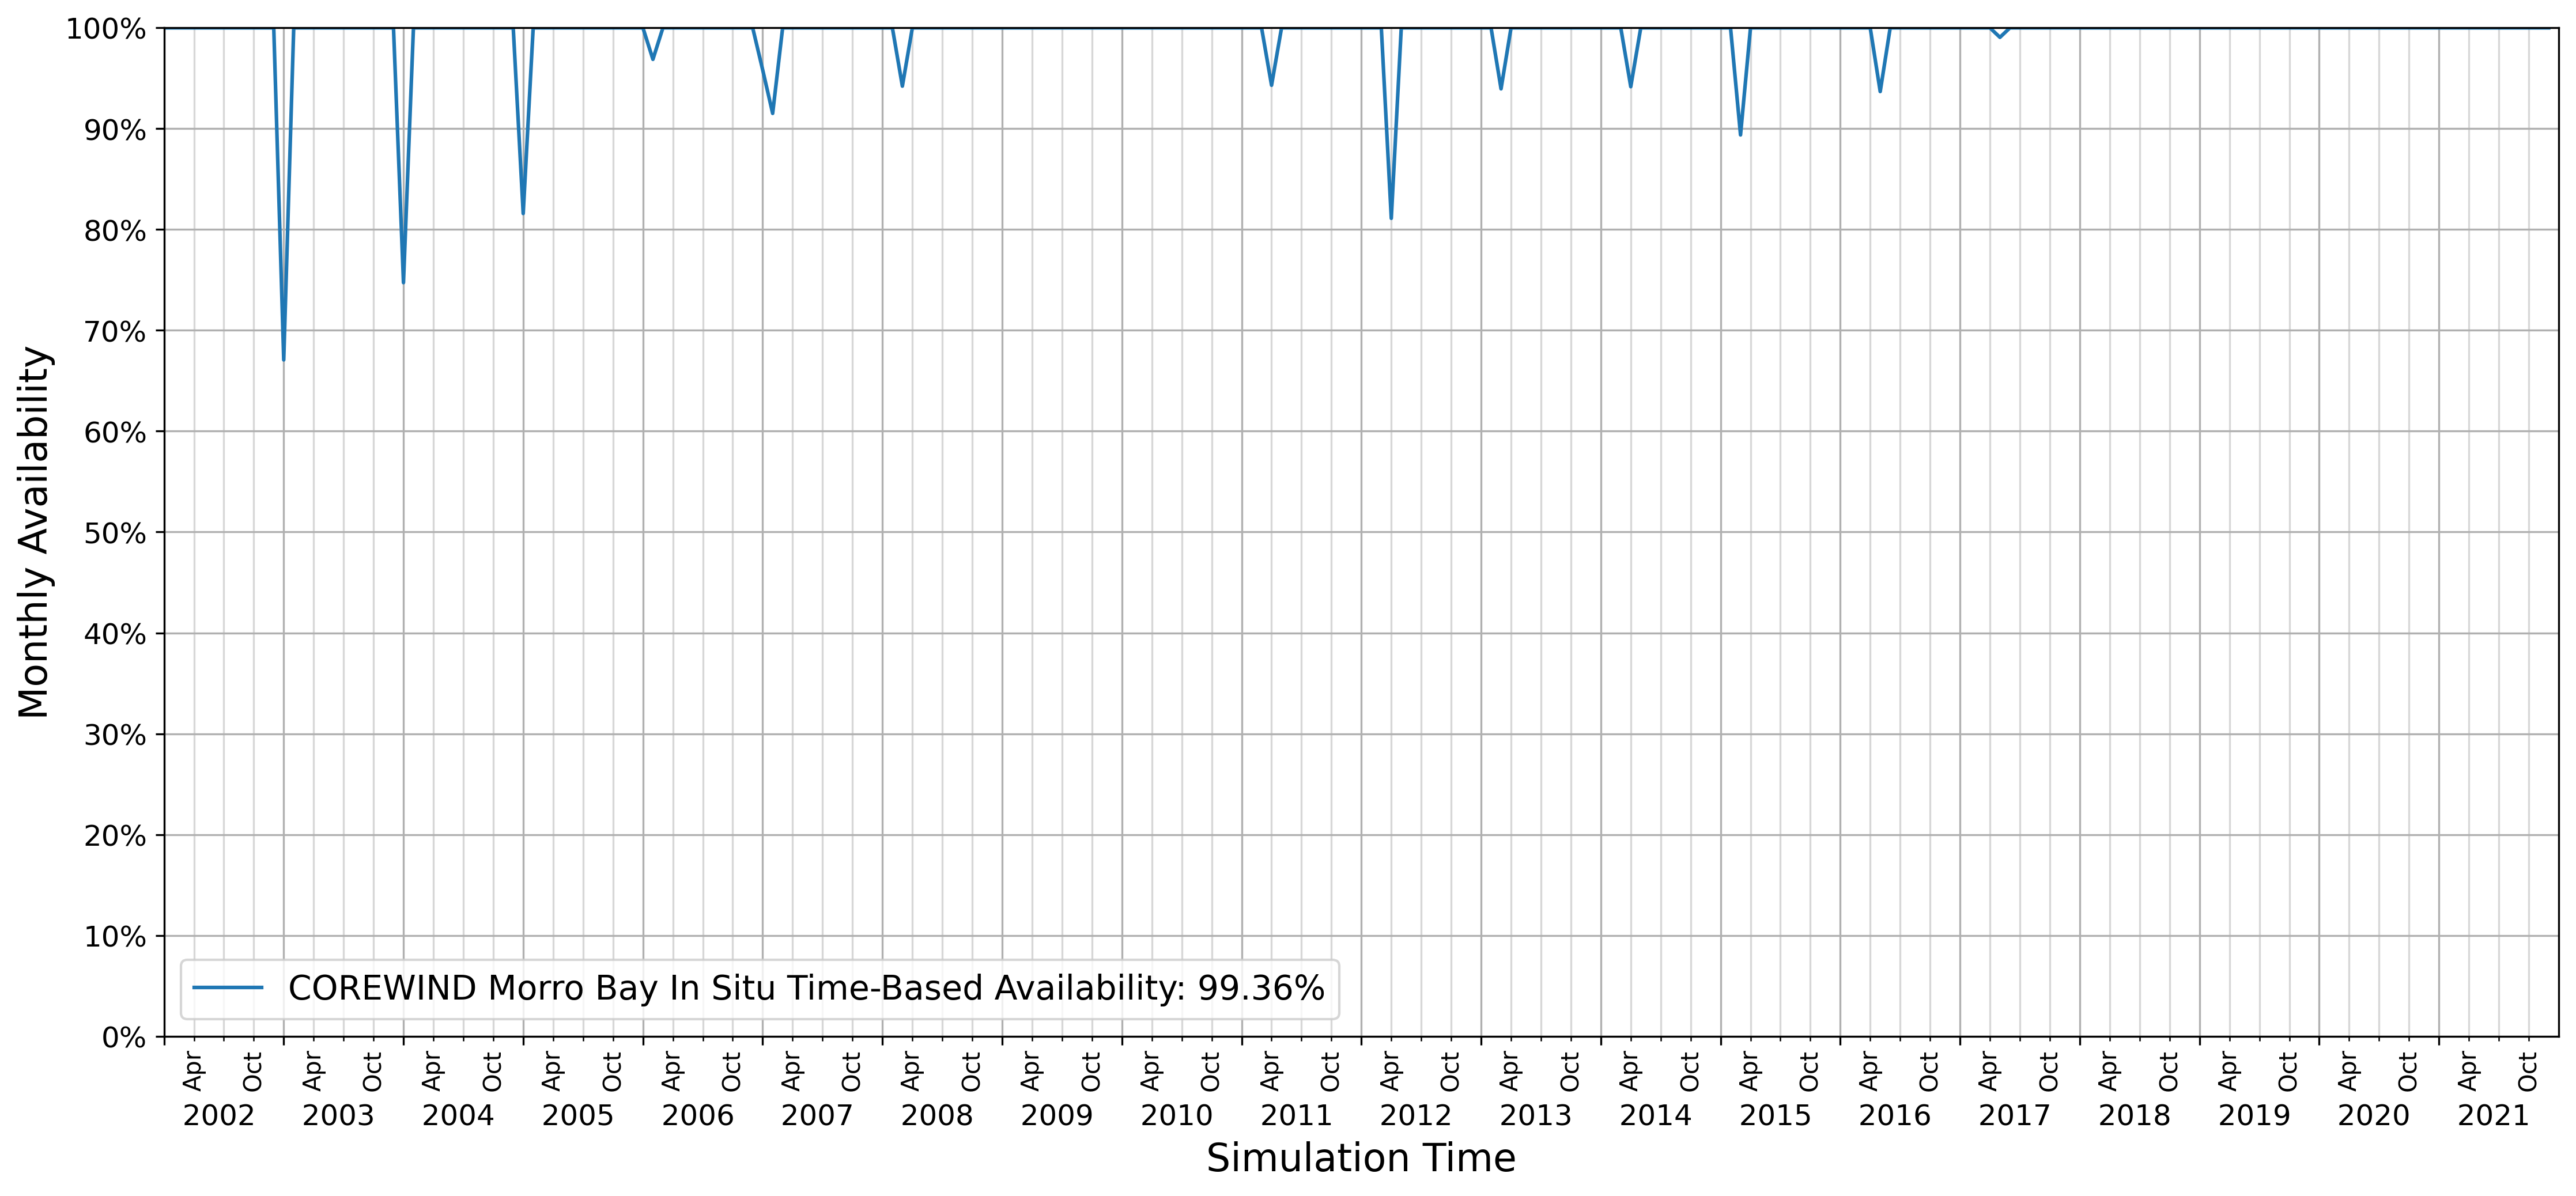

In [11]:
plot.plot_farm_availability(sim_in_situ, which="time")

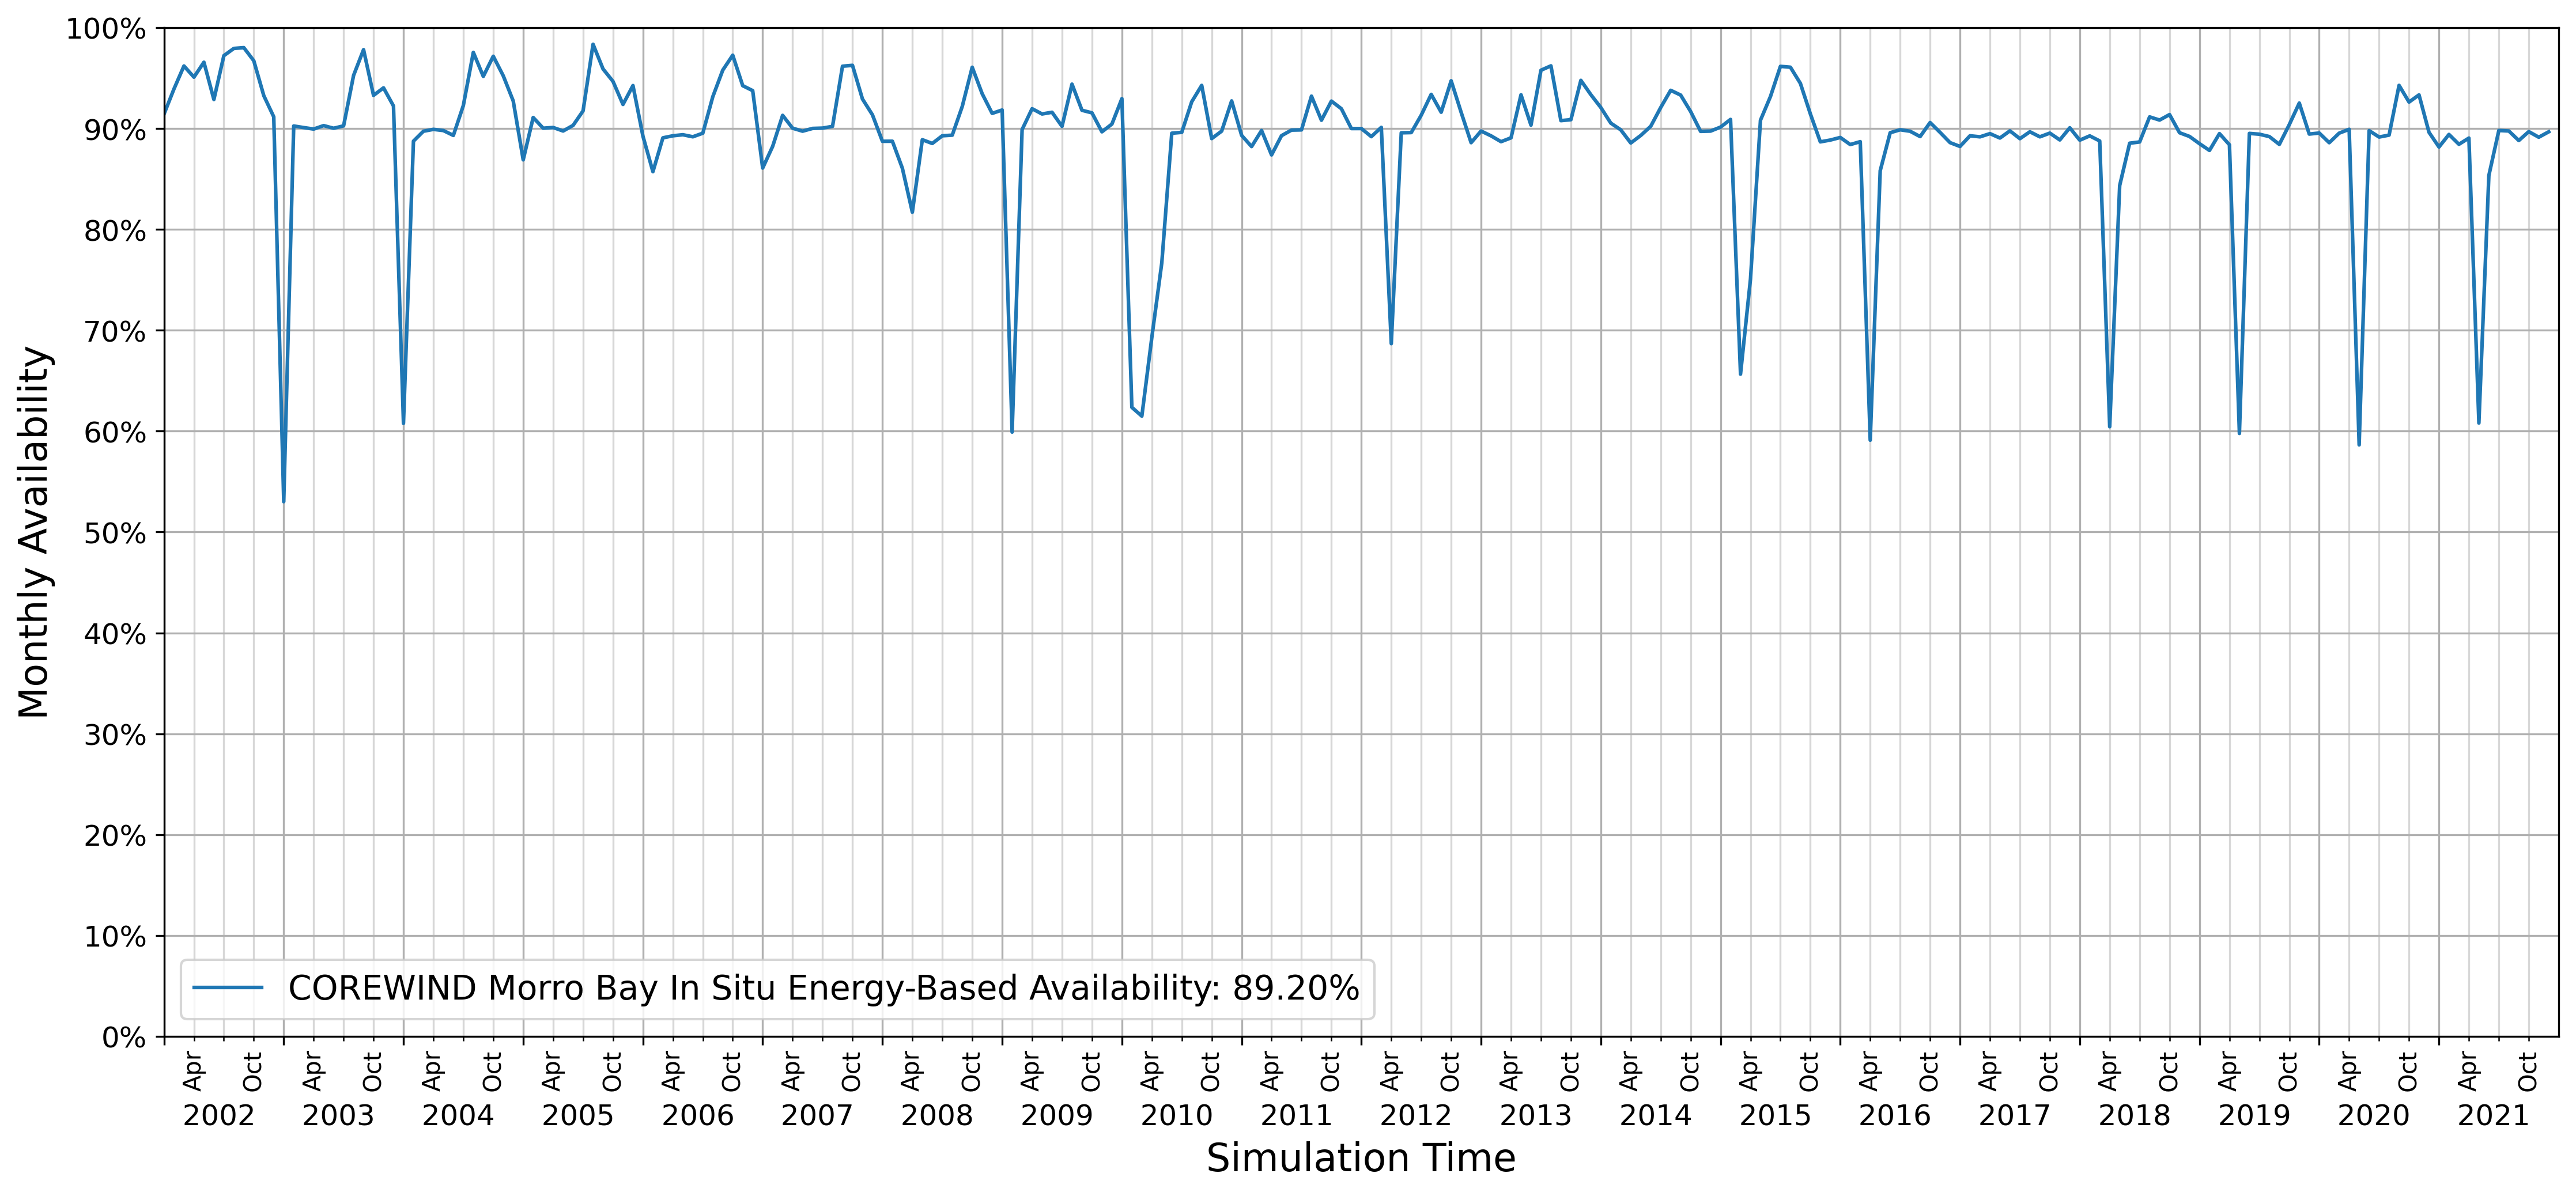

In [12]:
plot.plot_farm_availability(sim_in_situ, which="energy")

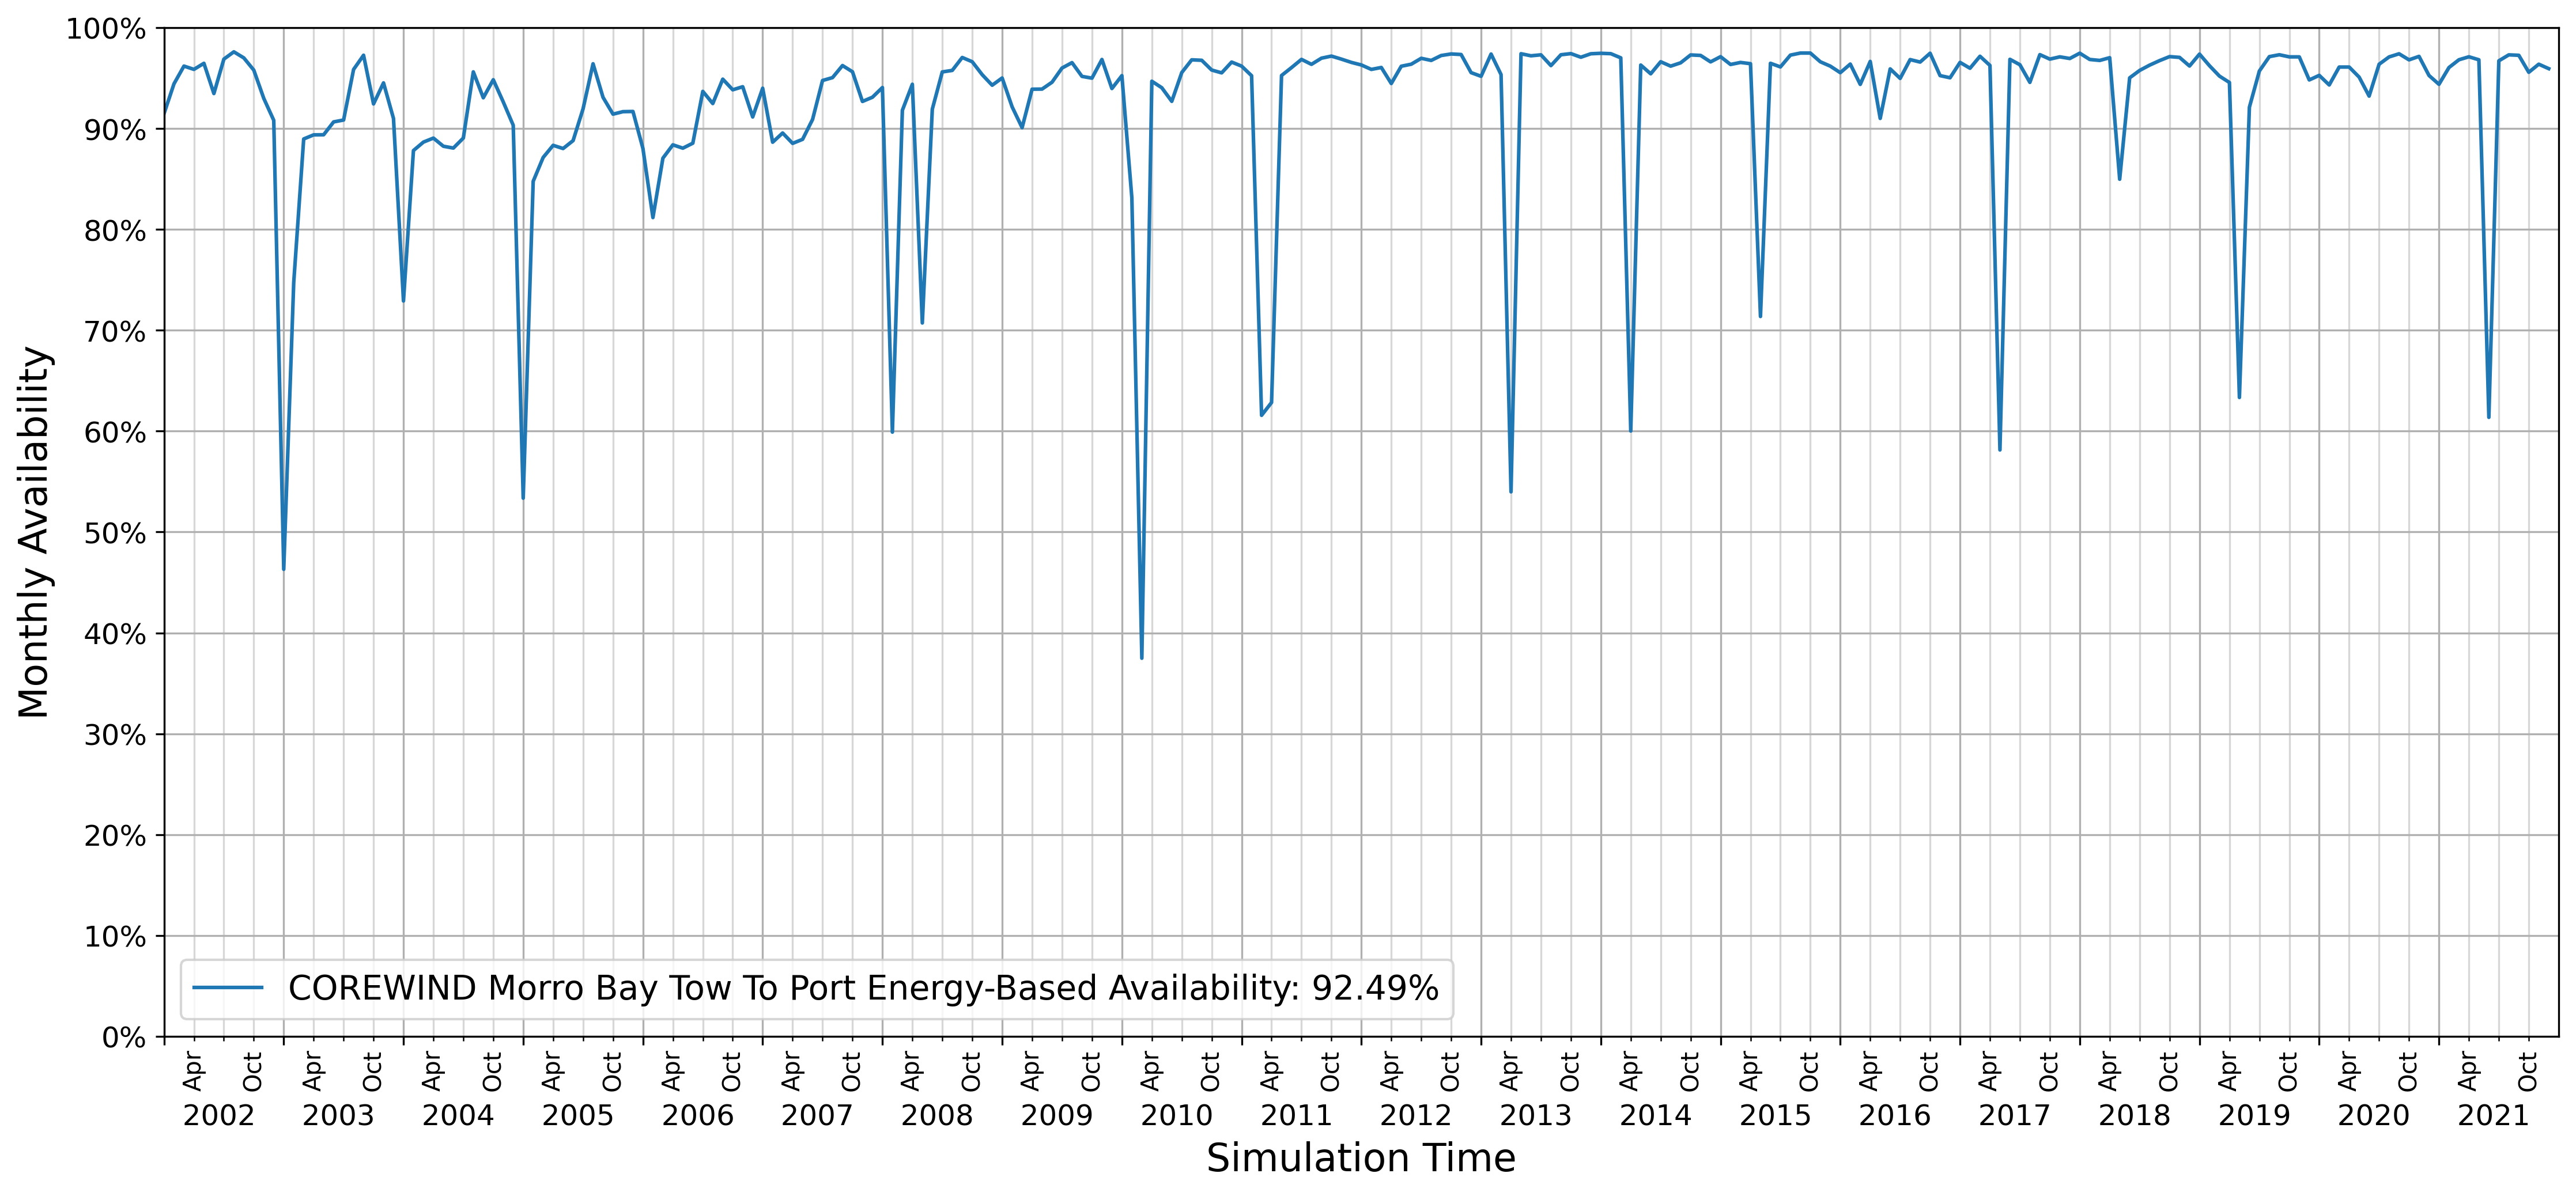

In [13]:
plot.plot_farm_availability(sim_ttp)

In the in situ case, we can see a large dip in availability in January 2003, and in the tow-to-port case we can see a large dip around February 2007, so let's investiage a bit further by diving into the events and operations logs that are available through the `Metrics` object.

In [14]:
ev_in_situ = sim_in_situ.metrics.events
op_in_situ = sim_in_situ.metrics.operations

In [15]:
op_in_situ.head()

,env_datetime,env_time,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004,WTG_0005,WTG_0006,WTG_0007,WTG_0008,WTG_0009,WTG_0100,WTG_0101,WTG_0102,WTG_0103,WTG_0104,WTG_0105,WTG_0106,WTG_0107,WTG_0108,WTG_0109,WTG_0200,WTG_0201,WTG_0202,WTG_0203,WTG_0204,WTG_0205,WTG_0206,WTG_0207,WTG_0208,WTG_0209,WTG_0300,WTG_0301,WTG_0302,WTG_0303,WTG_0304,WTG_0305,WTG_0306,WTG_0307,WTG_0308,WTG_0309,WTG_0400,WTG_0401,WTG_0402,WTG_0403,WTG_0404,WTG_0405,WTG_0406,WTG_0407,WTG_0408,WTG_0409,WTG_0500,WTG_0501,WTG_0502,WTG_0503,WTG_0504,WTG_0505,WTG_0506,WTG_0507,WTG_0508,WTG_0509,WTG_0600,WTG_0601,WTG_0602,WTG_0603,WTG_0604,WTG_0605,WTG_0606,WTG_0607,WTG_0608,WTG_0609,WTG_0700,WTG_0701,WTG_0702,WTG_0703,WTG_0704,WTG_0705,WTG_0706,WTG_0707,WTG_0708,WTG_0709,SS1,SS2,windfarm,year,month,day
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-24 11:19:18.321208,2002-01-01 00:00:00,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2023-10-24 11:19:18.347340,2002-01-01 01:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2023-10-24 11:19:18.347454,2002-01-01 02:00:00,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2023-10-24 11:19:18.347528,2002-01-01 03:00:00,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2023-10-24 11:19:18.347598,2002-01-01 04:00:00,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1


In [16]:
op_in_situ.loc[op_in_situ.windfarm < 0.45, ["env_datetime", "env_time", "windfarm"]].head(24)

,env_datetime,env_time,windfarm
datetime,,,
2023-10-24 11:19:20.161672,2003-01-20 11:00:00,9227,0.4375
2023-10-24 11:19:20.161936,2003-01-20 12:00:00,9228,0.0
2023-10-24 11:19:20.162005,2003-01-20 13:00:00,9229,0.0
2023-10-24 11:19:20.162070,2003-01-20 14:00:00,9230,0.0
2023-10-24 11:19:20.164266,2003-01-20 15:00:00,9231,0.0
2023-10-24 11:19:20.164459,2003-01-20 16:00:00,9232,0.0
2023-10-24 11:19:20.164530,2003-01-20 17:00:00,9233,0.0
2023-10-24 11:19:20.164672,2003-01-20 18:00:00,9234,0.0
2023-10-24 11:19:20.165974,2003-01-20 19:00:00,9235,0.0


In [17]:
ev_in_situ.head().T  # transposed because of a bug in Jupyter Lab 4.0

datetime,2023-10-24 11:19:14.556737,2023-10-24 11:19:14.563209,2023-10-24 11:19:14.569294,2023-10-24 11:19:14.575195,2023-10-24 11:19:14.581703
env_datetime,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00
env_time,0.0,0.0,0.0,0.0,0.0
agent,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
action,"subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '..."
reason,windfarm initialization,windfarm initialization,windfarm initialization,windfarm initialization,windfarm initialization
additional,initialization,initialization,initialization,initialization,initialization
system_id,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
system_name,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
part_id,<NA>,<NA>,<NA>,<NA>,<NA>
part_name,<NA>,<NA>,<NA>,<NA>,<NA>


In [18]:
# Get the core subset of columns to show
col_filter = ["env_datetime", "agent", "action", "reason", "additional", "system_id", "part_id", "request_id", "duration"]

In [19]:
ev_in_situ.loc[
    ev_in_situ.env_datetime >= "2003-01-20",
    col_filter
].head(50)

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2023-10-24 11:19:20.156319,2003-01-20 06:00:00,Crew Transfer Vessel 5,traveling,blades minor repair,traveling from port to site,WTG_0403,rotor_blades,RPR00000381,1.809689
2023-10-24 11:19:20.156456,2003-01-20 06:00:00,Crew Transfer Vessel 3,traveling,major pitch system repair,traveling from port to site,WTG_0505,hydraulic_system,RPR00000358,1.809705
2023-10-24 11:19:20.156595,2003-01-20 06:00:00,Crew Transfer Vessel 6,traveling,minor pitch system repair,traveling from port to site,WTG_0407,hydraulic_system,RPR00000313,1.809707
2023-10-24 11:19:20.156732,2003-01-20 06:00:00,Crew Transfer Vessel 1,traveling,minor pitch system repair,traveling from port to site,WTG_0004,hydraulic_system,RPR00000314,1.809725
2023-10-24 11:19:20.156866,2003-01-20 06:00:00,Crew Transfer Vessel 4,traveling,major pitch system repair,traveling from port to site,WTG_0409,hydraulic_system,RPR00000319,1.809782
2023-10-24 11:19:20.157006,2003-01-20 06:00:00,Crew Transfer Vessel 2,traveling,direct drive generator minor repair,traveling from port to site,WTG_0500,generator,RPR00000391,1.809821
2023-10-24 11:19:20.157139,2003-01-20 06:00:00,Crew Transfer Vessel 7,traveling,blades minor repair,traveling from port to site,WTG_0507,rotor_blades,RPR00000382,1.809892
2023-10-24 11:19:20.157279,2003-01-20 07:48:34,Crew Transfer Vessel 5,complete travel,blades minor repair,arrived at WTG_0403,WTG_0403,rotor_blades,RPR00000381,0.0
2023-10-24 11:19:20.157348,2003-01-20 07:48:34,Crew Transfer Vessel 5,transferring crew,blades minor repair,transferring crew from Crew Transfer Vessel 5 ...,WTG_0403,rotor_blades,RPR00000381,0.25


In [20]:
ev_in_situ.loc[
    ev_in_situ.env_datetime >= "2003-01-20 09:50",
    col_filter
].head(20)

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2023-10-24 11:19:20.159975,2003-01-20 09:54:47,Crew Transfer Vessel 2,complete transfer,direct drive generator minor repair,complete,WTG_0500,generator,RPR00000391,0.0
2023-10-24 11:19:20.160024,2003-01-20 09:54:47,Crew Transfer Vessel 2,repair complete,direct drive generator minor repair,complete,WTG_0500,generator,RPR00000391,0.0
2023-10-24 11:19:20.160646,2003-01-20 09:54:56,Crew Transfer Vessel 2,traveling,oss annual inspection,traveling from WTG_0500 to SS1,SS1,transformer,MNT00000325,0.212317
2023-10-24 11:19:20.160722,2003-01-20 10:07:41,Crew Transfer Vessel 2,complete travel,oss annual inspection,arrived at SS1,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.160817,2003-01-20 10:07:41,Crew Transfer Vessel 2,transferring crew,oss annual inspection,transferring crew from Crew Transfer Vessel 2 ...,SS1,transformer,MNT00000325,0.25
2023-10-24 11:19:20.160823,2003-01-20 10:22:41,Crew Transfer Vessel 2,complete transfer,oss annual inspection,complete,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.160917,2003-01-20 10:22:41,Crew Transfer Vessel 2,maintenance,oss annual inspection,maintenance,SS1,transformer,MNT00000325,11.371944
2023-10-24 11:19:20.160989,2003-01-20 10:36:27,Crew Transfer Vessel 7,transferring crew,blades minor repair,transferring crew from WTG_0507 to Crew Transf...,WTG_0507,rotor_blades,RPR00000382,0.25
2023-10-24 11:19:20.160995,2003-01-20 10:51:27,Crew Transfer Vessel 7,complete transfer,blades minor repair,complete,WTG_0507,rotor_blades,RPR00000382,0.0


In [21]:
ev_in_situ.loc[
    ev_in_situ.request_id == "MNT00000325",
    col_filter
]

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2023-10-24 11:19:20.052142,2003-01-01 00:00:00,transformer,maintenance request,oss annual inspection,severity level 1,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.160646,2003-01-20 09:54:56,Crew Transfer Vessel 2,traveling,oss annual inspection,traveling from WTG_0500 to SS1,SS1,transformer,MNT00000325,0.212317
2023-10-24 11:19:20.160722,2003-01-20 10:07:41,Crew Transfer Vessel 2,complete travel,oss annual inspection,arrived at SS1,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.160817,2003-01-20 10:07:41,Crew Transfer Vessel 2,transferring crew,oss annual inspection,transferring crew from Crew Transfer Vessel 2 ...,SS1,transformer,MNT00000325,0.25
2023-10-24 11:19:20.160823,2003-01-20 10:22:41,Crew Transfer Vessel 2,complete transfer,oss annual inspection,complete,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.160917,2003-01-20 10:22:41,Crew Transfer Vessel 2,maintenance,oss annual inspection,maintenance,SS1,transformer,MNT00000325,11.371944
2023-10-24 11:19:20.167437,2003-01-20 21:45:00,Crew Transfer Vessel 2,transferring crew,oss annual inspection,transferring crew from SS1 to Crew Transfer Ve...,SS1,transformer,MNT00000325,0.25
2023-10-24 11:19:20.167990,2003-01-20 22:00:00,Crew Transfer Vessel 2,complete transfer,oss annual inspection,complete,SS1,transformer,MNT00000325,0.0
2023-10-24 11:19:20.168120,2003-01-20 22:00:00,Crew Transfer Vessel 2,traveling,oss annual inspection,traveling from site to port,SS1,transformer,MNT00000325,1.809738


In [22]:
ev_in_situ.loc[
    ev_in_situ.request_id == "MNT00000326",
    col_filter
]

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2023-10-24 11:19:20.052170,2003-01-01 00:00:00,transformer,maintenance request,oss annual inspection,severity level 1,SS2,transformer,MNT00000326,0.0
2023-10-24 11:19:20.161665,2003-01-20 10:51:33,Crew Transfer Vessel 7,traveling,oss annual inspection,traveling from WTG_0507 to SS2,SS2,transformer,MNT00000326,0.467544
2023-10-24 11:19:20.161740,2003-01-20 11:19:36,Crew Transfer Vessel 7,complete travel,oss annual inspection,arrived at SS2,SS2,transformer,MNT00000326,0.0
2023-10-24 11:19:20.161833,2003-01-20 11:19:36,Crew Transfer Vessel 7,transferring crew,oss annual inspection,transferring crew from Crew Transfer Vessel 7 ...,SS2,transformer,MNT00000326,0.25
2023-10-24 11:19:20.161839,2003-01-20 11:34:36,Crew Transfer Vessel 7,complete transfer,oss annual inspection,complete,SS2,transformer,MNT00000326,0.0
2023-10-24 11:19:20.161932,2003-01-20 11:34:36,Crew Transfer Vessel 7,maintenance,oss annual inspection,maintenance,SS2,transformer,MNT00000326,10.173333
2023-10-24 11:19:20.167626,2003-01-20 21:45:00,Crew Transfer Vessel 7,transferring crew,oss annual inspection,transferring crew from SS2 to Crew Transfer Ve...,SS2,transformer,MNT00000326,0.25
2023-10-24 11:19:20.168393,2003-01-20 22:00:00,Crew Transfer Vessel 7,complete transfer,oss annual inspection,complete,SS2,transformer,MNT00000326,0.0
2023-10-24 11:19:20.168518,2003-01-20 22:00:00,Crew Transfer Vessel 7,traveling,oss annual inspection,traveling from site to port,SS2,transformer,MNT00000326,1.809828


So there are 2 simultaneous dips in availability, first from maintenance on the the upstream substation (SS1), and then from maintenance on the main, interconnection-connected substation (SS2), which then causes a shutdown at the entire plant.

So then what happens for the tow-to-port case?

In [23]:
# Exercise for those that want to try it on their own

### Cost breakdowns

In [24]:
project_mw = sim_in_situ.windfarm.capacity / 1000

In [25]:
opex = sim_in_situ.metrics.opex("project")
opex.index = ["In Situ"]
opex.loc["Tow-to-Port", "OpEx"] = sim_ttp.metrics.opex("project").values[0]
opex["OpEx (€/MW/yr)"] = opex.OpEx / project_mw / 20
opex = opex.rename(columns={"OpEx": "OpEx (€)"})
opex.style.format("{:,.2f}")

,OpEx (€),OpEx (€/MW/yr)
In Situ,"2,627,559,225.85","109,481.63"
Tow-to-Port,"1,669,481,396.18","69,561.72"


In [26]:
opex_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project"),
        sim_in_situ.metrics.labor_costs("project"),
        sim_in_situ.metrics.project_fixed_costs("project", "low"),
        sim_in_situ.metrics.port_fees("project"),
    ],
    axis=1
)
opex_breakdown.index = ["In Situ"]
opex_breakdown.loc["Tow-to-Port"] = pd.concat(
    [
        sim_ttp.metrics.equipment_costs("project"),
        sim_ttp.metrics.labor_costs("project"),
        sim_ttp.metrics.project_fixed_costs("project", "low"),
        sim_ttp.metrics.port_fees("project"),
    ],
    axis=1
).values[0]
opex_breakdown.style.format("{:,.2f}")

,equipment_cost,total_labor_cost,operations,port_fees
In Situ,"2,507,009,405.10","53,297,496.75",0.00,0.00
Tow-to-Port,"1,059,248,077.43","73,770,382.75",0.00,"480,000,000.00"


Why might the OpEx for tow-to-port be so low?

In [27]:
equipment_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project", by_equipment=True).T.rename(columns={0: "In Situ"}),
        sim_ttp.metrics.equipment_costs("project", by_equipment=True).T.rename(columns={0: "Tow-to-Port"}),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_breakdown.style.format("{:,.2f}")

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:740: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  costs = costs.fillna(costs.max(axis=0)).T
/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:740: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  costs = costs.fillna(costs.max(axis=0)).T


,In Situ,Tow-to-Port
Anchor Handling Tug,"183,182,504.92","355,551,986.65"
Cable Laying Vessel,"156,923,649.78","133,852,669.25"
Crew Transfer Vessel 1,"25,563,370.47","25,562,764.84"
Crew Transfer Vessel 2,"25,563,357.03","25,562,764.04"
Crew Transfer Vessel 3,"25,563,348.17","25,562,740.47"
Crew Transfer Vessel 4,"25,563,351.85","25,562,717.86"
Crew Transfer Vessel 5,"25,563,349.01","25,562,704.46"
Crew Transfer Vessel 6,"25,563,372.45","25,562,723.04"
Crew Transfer Vessel 7,"25,563,360.51","25,562,710.29"
Diving Support Vessel,"187,610,296.15","371,891,657.28"


It should be noted that there are a couple limitations to WOMBAT and this data:
1. There was no port cost data provided, so it doesn't exist in the totals
2. Tugboats don't currently get mobilized, so those costs are missing from the equation
3. Tugboats are only actively accruing costs during their towing and travel duties, and not during the between time

### Operational performance

Were the vessels used consistently throughout the simulation period? Note that the below metric probably needs to be updated to be more reflective of vessel inactive time, such as time between shifts, so there are some limitations to the current model

In [28]:
equipment_utilization = pd.concat(
    [
        sim_in_situ.metrics.service_equipment_utilization("project").T.rename(columns={0: "In Situ"}),
        sim_ttp.metrics.service_equipment_utilization("project").T.rename(columns={0: "Tow-to-Port"}),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_utilization.style.format("{:,.2f}")

,In Situ,Tow-to-Port
Anchor Handling Tug,0.87,0.99
Cable Laying Vessel,0.92,0.90
Crew Transfer Vessel 1,1.00,1.00
Crew Transfer Vessel 2,1.00,1.00
Crew Transfer Vessel 3,1.00,1.00
Crew Transfer Vessel 4,1.00,1.00
Crew Transfer Vessel 5,1.00,1.00
Crew Transfer Vessel 6,1.00,1.00
Crew Transfer Vessel 7,1.00,1.00
Diving Support Vessel,0.96,0.98


What if we also look at the task completion rate? It seems that the tow-to-port scenario isn't actually getting tasks completed, so let's dig deeper.

In [29]:
print("In Situ")
scheduled = sim_in_situ.metrics.task_completion_rate(which="scheduled", frequency="project").values[0][0]
unscheduled = sim_in_situ.metrics.task_completion_rate(which="unscheduled", frequency="project").values[0][0]
combined = sim_in_situ.metrics.task_completion_rate(which="both", frequency="project").values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")
print()
print("Tow-to-Port")
scheduled = sim_ttp.metrics.task_completion_rate(which="scheduled", frequency="project").values[0][0]
unscheduled = sim_ttp.metrics.task_completion_rate(which="unscheduled", frequency="project").values[0][0]
combined = sim_ttp.metrics.task_completion_rate(which="both", frequency="project").values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")

In Situ
  Scheduled Task Completion Rate: 94.41%
Unscheduled Task Completion Rate: 93.88%
    Overall Task Completion Rate: 94.08%

Tow-to-Port
  Scheduled Task Completion Rate: 71.11%
Unscheduled Task Completion Rate: 75.97%
    Overall Task Completion Rate: 74.14%


In [30]:
process_times = sim_ttp.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[time_columns].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).style.format("{:,.0f}")

,time_to_completion,process_time,downtime,time_to_start,N
category,,,,,
yaw system major replacement,"26,740",110,110,"26,630",2
minor ballast pump repair,"15,566",9,9,"15,560",31
yaw system major repair,"14,458",35,310,"14,149",14
main shaft major repair,"13,520",36,"1,602","12,447",59
direct drive generator minor repair,"13,007",20,138,"10,637","2,698"
annual turbine inspection,"12,962",28,182,"10,542","4,786"
main shaft minor repair,"12,890",14,28,"10,984",604
direct drive generator major repair,"12,478",39,676,"9,200",130
structural annual inspection,"11,511",19,58,"3,195","5,207"


How does that compare to the in situ case for some of our worst offenders?

In [31]:
process_times = sim_in_situ.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[time_columns].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).head(10).style.format("{:,.0f}")

,time_to_completion,process_time,downtime,time_to_start,N
category,,,,,
power converter major repair,"9,672",4,4,77,"1,030"
power electrical system major repair,"7,822",27,27,712,48
major pitch system replacement,"7,717",228,228,"7,557",2
main shaft major repair,"5,313",52,52,"2,139",34
power converter replacement,"4,565",473,682,"3,493",238
yaw system major replacement,"3,483",448,448,"3,046",1
blades major replacement,"3,062","2,529","2,528",534,1
direct drive generator major repair,"2,083",85,85,"2,010",42
structural subsea inspection,"1,480",35,90,"1,434","1,108"


## What Next?

- What happens if we add more crew slots at the port to get repairs done?
- What if we add another HLV, does more work get done, or do we just divvy up the tasks more evenly?
- How about port fees, what if we use ORBIT to supplement the port fees?
- How do labor rates impact the analysis?